In [40]:
import tensorflow as tf
import numpy as np # for numerical operations and linear algebra
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
from typing import Tuple
from tqdm import tqdm
import keras


image_dir = "/mnt/c/Users/austi/Downloads/datasetImages_warp256/"
label_csv_path = "/mnt/c/Users/austi/Downloads/"


batch_size = 32
epochs = 3




In [41]:
toPILImage = lambda x: tf.keras.preprocessing.image.array_to_img(x)

In [42]:
class AADB(tf.keras.utils.Sequence):
    attributes = [
        "balancing_elements",
        "color_harmony",
        "content",
        "depth_of_field",
        "light",
        "motion_blur",
        "object",
        "repetition",
        "rule_of_thirds",
        "symmetry",
        "vivid_color",
        "score",
    ]

    def preprocess_image(self, image):
        image = tf.image.resize(image, [256, 256])
        image = tf.cast(image, tf.float32) / 255.0
        return image

    def __init__(self, image_dir, label_csv_path, batch_size=32, test=False):
        self.label_csv_path = label_csv_path
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.test = test

        self.transform = tf.keras.Sequential([
            tf.keras.layers.Rescaling(1./255),
            tf.keras.layers.Resizing(256, 256),

        ])
        self.files, self.labels = self.load_data(self.image_dir, self.label_csv_path, self.test)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        image = Image.open(self.files[index]).convert('RGB')
        image = self.transform(tf.convert_to_tensor(image))
        assert image.shape == (256, 256, 3)
        #label = torch.from_numpy(self.labels[index])
        label = tf.convert_to_tensor(self.labels[index], dtype=tf.float32)
        return image, label


    def load_data(self, image_dir, csv_path, test=False):
        csv_file = csv_path + 'Dataset.csv' if not test else csv_path + 'Dataset_test.csv'
        label_csv = pd.read_csv(csv_file, delimiter=",")
        files = [os.path.join(image_dir, f) for f in label_csv['ImageFile']]
        #labels = label_csv.drop(['ImageFile'], axis=1).values
        labels = []
        for index, label in label_csv.drop(['ImageFile'], axis=1).iterrows(): 
            label = list(label.values)
            label.append(label.pop(9))
            labels.append(label)

        # Moving 'score' to the last column
        labels = np.asarray(labels)
        return files, labels

In [43]:
aadb = AADB(image_dir, label_csv_path)

In [44]:
def show_example(img, label):
    print(label)
    plt.imshow(img)

In [45]:
def show_batch(dataset):
    for images, labels in dataset.take(1):
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        images = tf.concat(tf.unstack(images, axis=0), axis=1)  # Concatenate images horizontally
        ax.imshow(images)
        break

tf.Tensor([-0.2  0.2 -0.2 -0.4  0.   0.  -0.4  0.  -0.2  0.   0.3  0. ], shape=(12,), dtype=float32)


8958

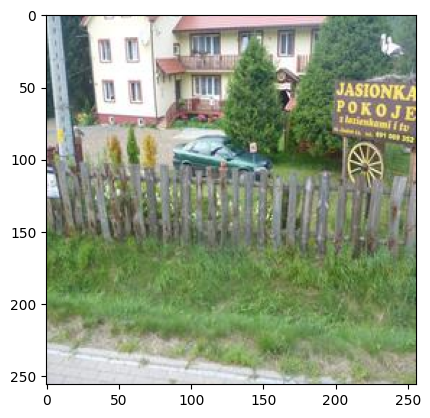

In [46]:
show_example(*aadb[0])
len(aadb)

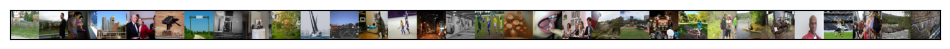

In [47]:


#train_ds, val_ds = random_split(aadb, [train_size, val_size])
#train_ds, val_ds = tf.data.Dataset.from_tensor_slices(aadb.files[:train_size]), tf.data.Dataset.from_tensor_slices(aadb.files[train_size:])
val_size = 500
train_size = len(aadb.files) - val_size

train_ds = tf.data.Dataset.from_generator(
    lambda: aadb,
    output_types=(tf.float32, tf.float32),
    output_shapes=((256, 256, 3), (12,))
).take(train_size)

val_ds = tf.data.Dataset.from_generator(
    lambda: aadb,
    output_types=(tf.float32, tf.float32),
    output_shapes=((256, 256, 3), (12,))
).skip(train_size)

train_ds = train_ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

show_batch(train_ds)


In [48]:
class RankLoss(tf.keras.losses.Loss):

    def __init__(self, margin):
        super().__init__()
        self.margin = margin

    def call(self, y_true, y_pred):
        # Calculate target
        target = tf.ones_like(y_true[0], dtype=y_pred[0].dtype)

        # Set indices where y_true1 < y_true2 to -1
        target = tf.where(y_true[0] < y_true[1], -1.0 * tf.ones_like(target), target)

        # Calculate margin ranking loss
        loss = tf.maximum(0.0, self.margin - (y_pred[0] - y_pred[1]) * target)
        return tf.reduce_mean(loss)




class RegRankLoss(tf.keras.losses.Loss):

    def __init__(self, margin: float):
        super().__init__()
        self.reg_loss = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
        self.rank_loss = RankLoss(margin)

    def __call__(self,
        y_pred: Tuple[tf.Tensor, tf.Tensor],
        y_true: Tuple[tf.Tensor, tf.Tensor]) -> Tuple[tf.Tensor, tf.Tensor]:
        
        loss_reg = (
            self.reg_loss(y_pred[0], y_true[0]) +
            self.reg_loss(y_pred[1], y_true[1])
        ) / 2.0

        loss_rank = self.rank_loss(y_pred, y_true)
        loss = loss_reg + loss_rank
        return loss, loss_reg, loss_rank
    
    

In [49]:

def create_backbone(backbone_name, pretrained=True):
    """
    Creates a backbone model from a pre-trained model.
    Args:
        backbone_name (str): Name of the backbone model (e.g., 'resnet50').
        pretrained (bool): Whether to use pre-trained weights.
    Returns:
        tf.keras.Model: The backbone model.
    """
    backbone = getattr(tf.keras.applications, backbone_name)(
        include_top=False,
        weights='imagenet' if pretrained else None,
        input_shape=(256, 256, 3)  # Replace with your input shape
    )
    
    return backbone

    
def create_regression_network(backbone, num_attributes):
    """
    Creates a regression network using the given backbone.
    Args:
        backbone (tf.keras.Model): The backbone model.
        num_attributes (int): Number of attributes for the regression task.
    Returns:
        tf.keras.Model: The regression network.
    """
    inputs = backbone.input
    x = backbone.output

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(num_attributes, activation='linear')(x)
    model = tf.keras.Model(inputs, outputs)

    return model


In [50]:

#model = RegressionNetwork(backbone='ResNet50', num_attributes=len(attributes), pretrained=False)
backbone = create_backbone('MobileNetV2', pretrained=False)
backbone.trainable = True
num_layers = len(backbone.layers)
for layer in backbone.layers[:num_layers - 8]:
    layer.trainable = False
model = create_regression_network(backbone, 12)


In [51]:
loss_fn = RegRankLoss(margin=0.02)

In [58]:

optimizer = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
train_losses = []
train_losses_reg = []
train_losses_rank = []
val_losses = []

@tf.function
def train_step(x_batch, y_batch):
    with tf.GradientTape() as tape:
        x1, x2 = tf.split(x_batch, 2, axis=0)
        y1, y2 = tf.split(y_batch, 2, axis=0)
        y_pred1 = model(x1, training=True)
        y_pred2 = model(x2, training=True)
        loss, loss_reg, loss_rank = loss_fn(y_pred=(y_pred1, y_pred2), y_true=(y1, y2))

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, loss_reg, loss_rank

@tf.function
def val_step(x_batch, y_batch):
    y_pred = model(x_batch, training=False)
    val_loss = tf.keras.losses.MeanSquaredError()(y_pred=y_pred, y_true=y_batch)
    return val_loss

try:
    checkpoint.restore(manager.latest_checkpoint)
    print("Restored from {}".format(manager.latest_checkpoint))
    model.load_weights('model.h5')
except Exception as e:
    print(f"Error restoring checkpoint: {e}")

for epoch in range(epochs):
    train_batch_count = 0
    for x_batch, y_batch in train_ds:
        loss, loss_reg, loss_rank = train_step(x_batch, y_batch)
        print(f"Epoch {epoch+1}/{epochs}, Batch {train_batch_count+1}, Reg Loss: {loss_reg:.4f}, Rank Loss: {loss_rank:.4f}", end="\r")
        train_losses.append(loss)
        train_losses_reg.append(loss_reg)
        train_losses_rank.append(loss_rank)
        train_batch_count += 1

    val_loss = 0.0
    val_batch_count = 0
    for x_batch, y_batch in val_ds:
        val_loss += val_step(x_batch, y_batch)
        val_batch_count += 1
    val_loss /= val_batch_count
    val_losses.append(val_loss)

    print(f"\nEpoch {epoch+1}/{epochs}, Val Loss: {val_loss:.4f}")
    manager.save()

    checkpoint.save(file_prefix=checkpoint_prefix)
    model.save(f'{epoch}_model.keras')
    print(f"\nSaved checkpoint for epoch {epoch}.")

Restored from ./checkpoints/ckpt-3


2024-03-29 15:14:06.473561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-29 15:15:07.424600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 1/3, Val Loss: 0.1158



Saved checkpoint for epoch 0.


2024-03-29 15:16:14.189069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-29 15:17:11.180006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 2/3, Val Loss: 0.1128



Saved checkpoint for epoch 1.


2024-03-29 15:18:21.596237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-29 15:19:18.026021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 3/3, Val Loss: 0.1102



Saved checkpoint for epoch 2.


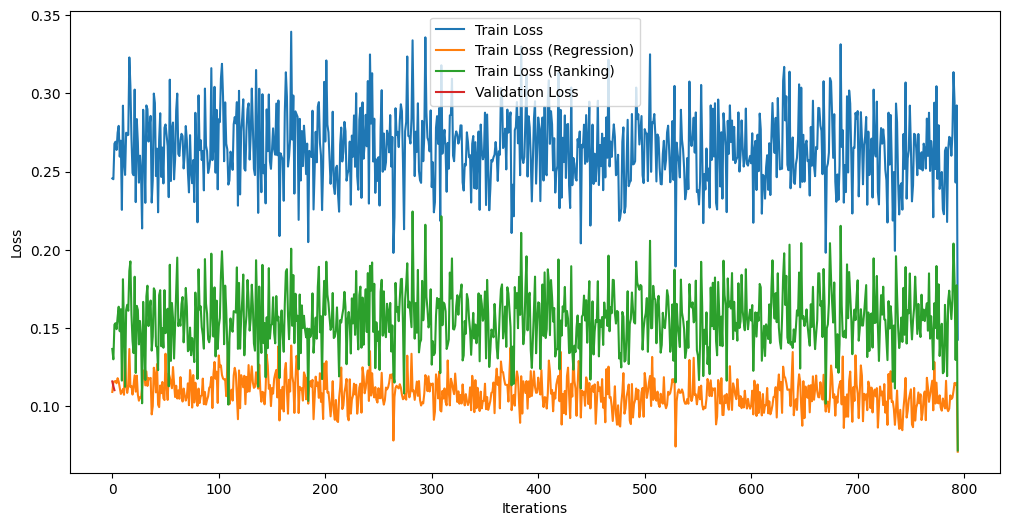

In [59]:
# plot losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(train_losses_reg, label='Train Loss (Regression)')
plt.plot(train_losses_rank, label='Train Loss (Ranking)')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()



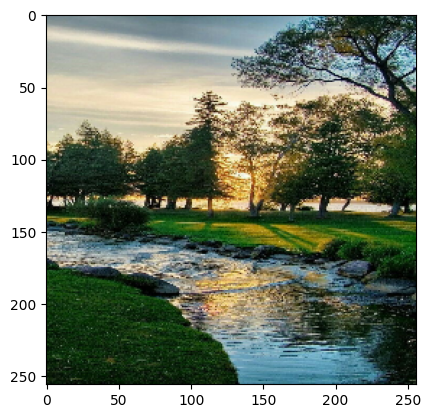

Prediction: {'balancing_elements': 0.012745746, 'color_harmony': 0.088767186, 'content': 0.07611815, 'depth_of_field': 0.019174647, 'light': 0.0054356037, 'motion_blur': -0.004314041, 'object': 0.020821918, 'repetition': 0.021901505, 'rule_of_thirds': -0.0029271338, 'symmetry': -0.0029641672, 'vivid_color': 0.1783805, 'score': 0.007677342}


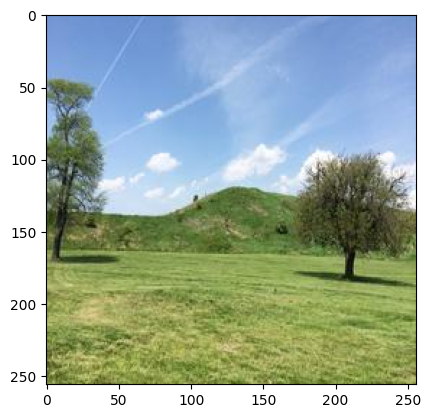

Prediction: {'balancing_elements': 0.012745746, 'color_harmony': 0.088767186, 'content': 0.07611815, 'depth_of_field': 0.019174647, 'light': 0.0054356037, 'motion_blur': -0.004314041, 'object': 0.020821918, 'repetition': 0.021901505, 'rule_of_thirds': -0.0029271338, 'symmetry': -0.0029641672, 'vivid_color': 0.1783805, 'score': 0.007677342}


In [62]:
attributes = [
    "balancing_elements",
    "color_harmony",
    "content",
    "depth_of_field",
    "light",
    "motion_blur",
    "object",
    "repetition",
    "rule_of_thirds",
    "symmetry",
    "vivid_color",
    "score",
]

def show_prediction_custom(image_path):
    image = Image.open(image_path).convert('RGB')
    image = aadb.preprocess_image(image)
    image = tf.expand_dims(image, axis=0)
    
    model_path = '2_model.h5'
    model = tf.keras.models.load_model(model_path)
    prediction = model(image)
    prediction = {attributes[i]: prediction[0][i].numpy() for i in range(len(attributes))}
    plt.imshow(toPILImage(image[0]))
    plt.show()
    print(f'Prediction: {prediction}')


show_prediction_custom('/mnt/c/Users/austi/Downloads/nice.jpg')
show_prediction_custom('/mnt/c/Users/austi/Downloads/datasetImages_warp256/farm1_276_19536573313_156d174531_b.jpg')
